# Language Modeling using RNNs: Machine Translation (English-French)
> [Reference](https://github.com/tommytracey/AIND-Capstone/blob/master/machine_translation.ipynb)

In [1]:
import os
import collections
import numpy as np

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

2023-05-10 21:57:39.730391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

english_sentences = load_data('data/small_vocab_en')
french_sentences = load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


In [3]:
for i in range(5):
    print('English sample {}:  {}'.format(i + 1, english_sentences[i]))
    print('French sample {}:  {}\n'.format(i + 1, french_sentences[i]))

English sample 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
French sample 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

English sample 2:  the united states is usually chilly during july , and it is usually freezing in november .
French sample 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .

English sample 3:  california is usually quiet during march , and it is usually hot in june .
French sample 3:  california est généralement calme en mars , et il est généralement chaud en juin .

English sample 4:  the united states is sometimes mild during june , and it is cold in september .
French sample 4:  les états-unis est parfois légère en juin , et il fait froid en septembre .

English sample 5:  your least liked fruit is the grape , but my least liked is the apple .
French sample 5:  votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme .



## Vocabulary

In [4]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


## Preprocess
Convert text to integer sequences.

In [5]:
# tokenize
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print("TOKENIZER WORD INDEX:")
print(text_tokenizer.word_index)
print('-'*40)
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in text_sentences'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

TOKENIZER WORD INDEX:
{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}
----------------------------------------
Sequence 1 in text_sentences
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in text_sentences
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in text_sentences
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the end of each sequence using Keras's pad_sequences function.

In [6]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    return pad_sequences(x, maxlen=length, padding='post')

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in text_tokenized'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))
    print('  Length: {}'.format(len(pad_sent)))

Sequence 1 in text_tokenized
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
  Length: 10
Sequence 2 in text_tokenized
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
  Length: 10
Sequence 3 in text_tokenized
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]
  Length: 10


In [7]:
# preprocess pipeline
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer = preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


## Convert Integers to Text

The neural network will be translating the input to words ids, which isn't the final form we want. We want the French translation. This function is to better understand the output of the neural network.

In [8]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


## RNN Model: GRU
![](images/rnn.png)

In [13]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # Hyperparameters
    learning_rate = 0.005
    
    model = Sequential()
    model.add(GRU(256, input_shape=input_shape[1:], return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size+1, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [14]:
# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

In [15]:
# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

print(simple_rnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 21, 256)           198912    
                                                                 
 time_distributed_2 (TimeDis  (None, 21, 1024)         263168    
 tributed)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 21, 1024)          0         
                                                                 
 time_distributed_3 (TimeDis  (None, 21, 345)          353625    
 tributed)                                                       
                                                                 
Total params: 815,705
Trainable params: 815,705
Non-trainable params: 0
_________________________________________________________________
None


2023-05-10 22:03:56.780896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 22:03:56.782524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 22:03:56.784043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [16]:
history = simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

Epoch 1/10


2023-05-10 22:03:57.330524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 22:03:57.332460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 22:03:57.334428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

108/108 [==============================] - ETA: 0s - loss: 1.9094 - accuracy: 0.5443

2023-05-10 22:05:23.476531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 22:05:23.478725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 22:05:23.480079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

108/108 [==============================] - 94s 847ms/step - loss: 1.9094 - accuracy: 0.5443 - val_loss: 1.2968 - val_accuracy: 0.6266
Epoch 2/10
108/108 [==============================] - 97s 901ms/step - loss: 1.2478 - accuracy: 0.6362 - val_loss: 1.1024 - val_accuracy: 0.6673
Epoch 3/10
108/108 [==============================] - 101s 931ms/step - loss: 1.1038 - accuracy: 0.6635 - val_loss: 0.9877 - val_accuracy: 0.6919
Epoch 4/10
108/108 [==============================] - 94s 875ms/step - loss: 1.0136 - accuracy: 0.6804 - val_loss: 0.9218 - val_accuracy: 0.7032
Epoch 5/10
108/108 [==============================] - 95s 881ms/step - loss: 0.9515 - accuracy: 0.6916 - val_loss: 0.8561 - val_accuracy: 0.7163
Epoch 6/10
108/108 [==============================] - 94s 870ms/step - loss: 0.9175 - accuracy: 0.6964 - val_loss: 0.8225 - val_accuracy: 0.7243
Epoch 7/10
108/108 [==============================] - 94s 868ms/step - loss: 0.8660 - accuracy: 0.7103 - val_loss: 0.7929 - val_accuracy: 0.

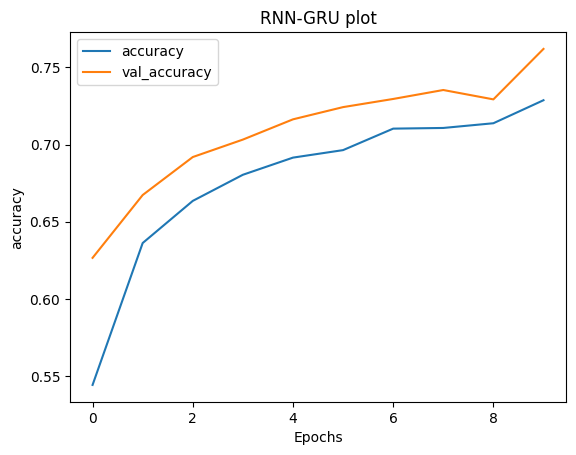

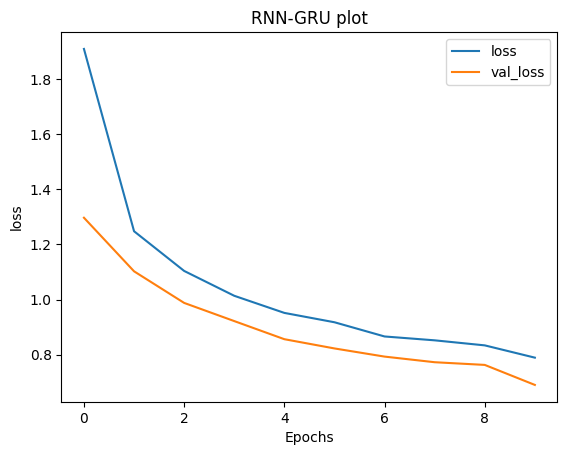

In [17]:
import matplotlib.pyplot as plt

def plot_graphs(history, string, model_name):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title(model_name + " plot")
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, 'accuracy', 'RNN-GRU')
plot_graphs(history, 'loss', 'RNN-GRU')

In [39]:
# Print prediction(s)
print("Prediction:")
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print("\nOriginal text:")
print(english_sentences[:1])

Prediction:
1/1 [==============================] - 0s 26ms/step
new jersey est parfois calme en mois de il et il est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']


## RNN + Embeddings
![](images/embedding.png)

In [44]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # Hyperparameters
    learning_rate = 0.005
    
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(GRU(256, return_sequences=True))    
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [45]:
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

In [46]:
embed_rnn_model = embed_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

embed_rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 21, 256)           51200     
                                                                 
 gru_3 (GRU)                 (None, 21, 256)           394752    
                                                                 
 time_distributed_6 (TimeDis  (None, 21, 1024)         263168    
 tributed)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 21, 1024)          0         
                                                                 
 time_distributed_7 (TimeDis  (None, 21, 345)          353625    
 tributed)                                                       
                                                                 
Total params: 1,062,745
Trainable params: 1,062,745
No

2023-05-10 23:02:24.357253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 23:02:24.359426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 23:02:24.361283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [47]:
history = embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

Epoch 1/10


2023-05-10 23:02:25.047844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 23:02:25.049647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 23:02:25.051398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

108/108 [==============================] - ETA: 0s - loss: 1.3280 - accuracy: 0.6879

2023-05-10 23:04:10.172319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 23:04:10.174217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 23:04:10.175626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

108/108 [==============================] - 114s 1s/step - loss: 1.3280 - accuracy: 0.6879 - val_loss: 0.4570 - val_accuracy: 0.8526
Epoch 2/10
108/108 [==============================] - 108s 1s/step - loss: 0.3877 - accuracy: 0.8723 - val_loss: 0.2928 - val_accuracy: 0.9008
Epoch 3/10
108/108 [==============================] - 110s 1s/step - loss: 0.2815 - accuracy: 0.9059 - val_loss: 0.2369 - val_accuracy: 0.9188
Epoch 4/10
108/108 [==============================] - 108s 1s/step - loss: 0.2382 - accuracy: 0.9191 - val_loss: 0.2129 - val_accuracy: 0.9270
Epoch 5/10
108/108 [==============================] - 108s 1s/step - loss: 0.2165 - accuracy: 0.9255 - val_loss: 0.2002 - val_accuracy: 0.9309
Epoch 6/10
108/108 [==============================] - 105s 977ms/step - loss: 0.2032 - accuracy: 0.9293 - val_loss: 0.1937 - val_accuracy: 0.9330
Epoch 7/10
108/108 [==============================] - 104s 962ms/step - loss: 0.1938 - accuracy: 0.9320 - val_loss: 0.1899 - val_accuracy: 0.9332
Epoc

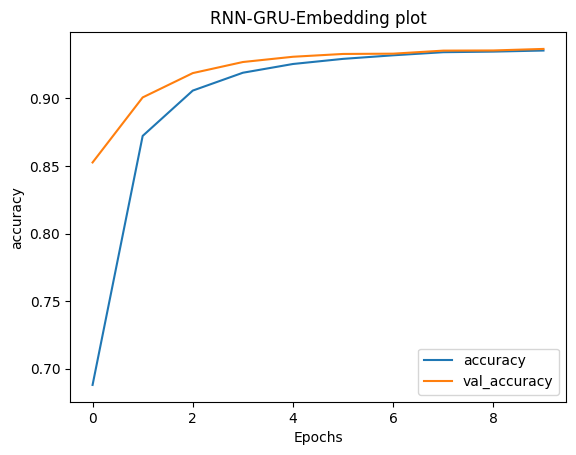

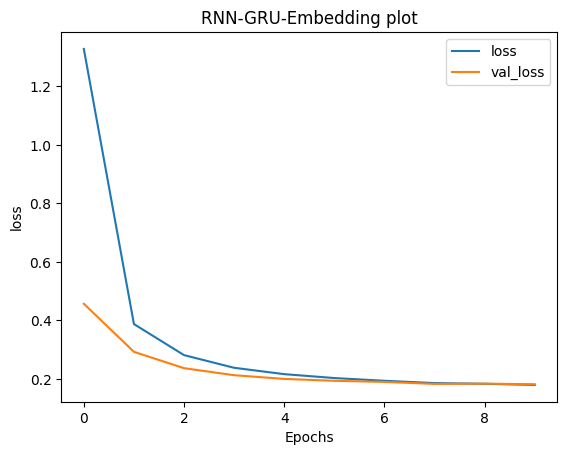

In [51]:
plot_graphs(history, 'accuracy', 'RNN-GRU-Embedding')
plot_graphs(history, 'loss', 'RNN-GRU-Embedding')

In [50]:
# Print prediction(s)
print("Prediction:")
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print("\nOriginal text:")
print(english_sentences[:1])

Prediction:
1/1 [==============================] - 0s 29ms/step
new jersey est parfois calme en l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']
